# Importing the relevant libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Preprocessing

### Importing the Database

In [75]:
raw_data = pd.read_csv('ml_datasource.csv')
print(raw_data.columns)
raw_data.head(5)

Index(['student_country', 'days_on_platform', 'minutes_watched',
       'courses_started', 'practice_exams_started', 'practice_exams_passed',
       'minutes_spent_on_exams', 'purchased'],
      dtype='object')


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


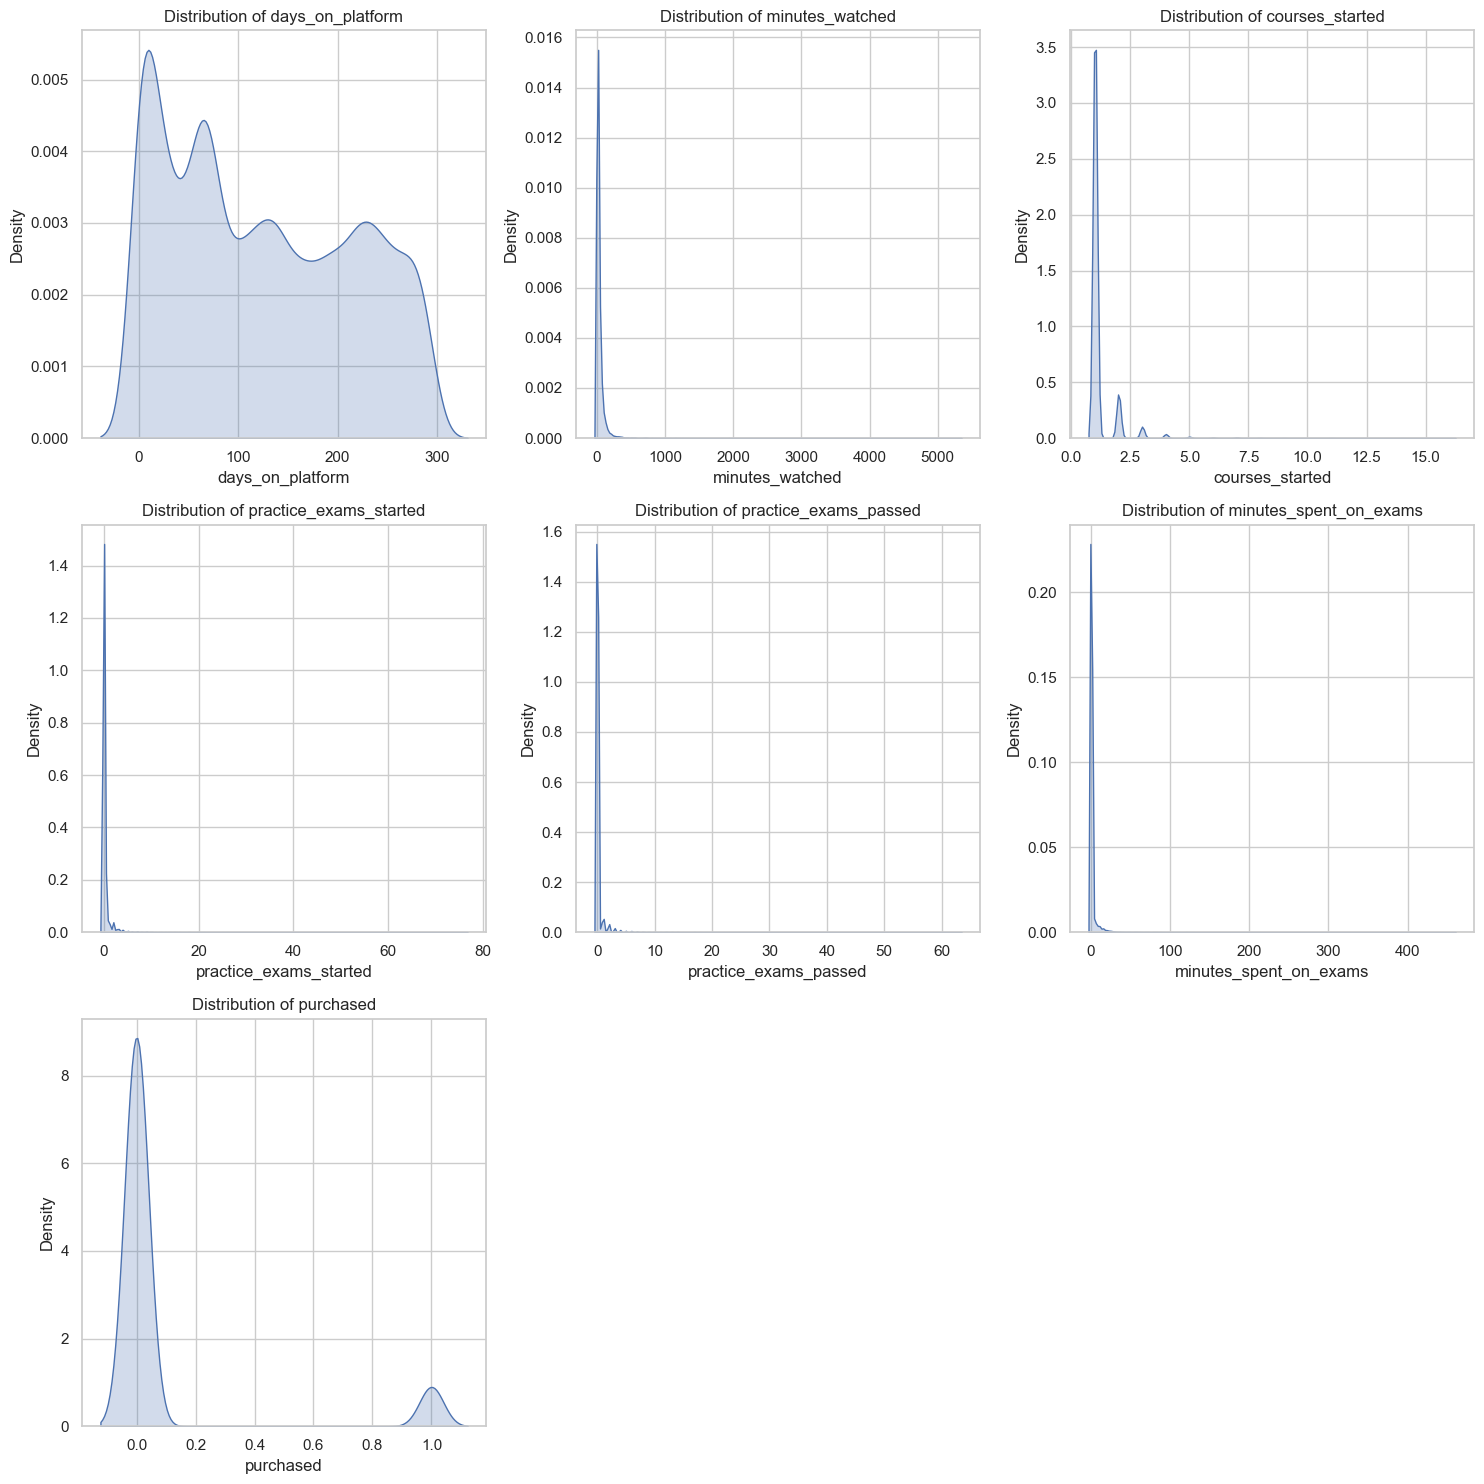

In [76]:
data = raw_data.copy()
# Set Seaborn theme
sns.set(style="whitegrid")

# Define numerical features
numerical_features = [
    "days_on_platform", "minutes_watched", "courses_started",
    "practice_exams_started", "practice_exams_passed",
    "minutes_spent_on_exams", "purchased"
]

# Determine grid size dynamically
num_features = len(numerical_features)
rows = (num_features // 3) + (num_features % 3 > 0)  # Number of rows (ceil division)
cols = min(3, num_features)  # Limit to 3 columns per row

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  # Flatten to 1D array for easier indexing

# Plot KDE distributions
for i, feature in enumerate(numerical_features):
    sns.kdeplot(data[feature], ax=axes[i], fill=True)
    axes[i].set_title(f"Distribution of {feature}")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Removing Outliers

In [77]:
# Step 1: Filter out outliers
data_no_outliers = data[
    (data["minutes_watched"] <= 1000) &
    (data["courses_started"] <= 10) &
    (data["practice_exams_started"] <= 10) &
    (data["minutes_spent_on_exams"] <= 40)
]

# Step 2: Display the shape of the data before and after filtering
print(f"Original data shape: {data.shape}")
print(f"Filtered data shape: {data_no_outliers.shape}")

data_no_outliers.head(5)

Original data shape: (17761, 8)
Filtered data shape: (17626, 8)


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


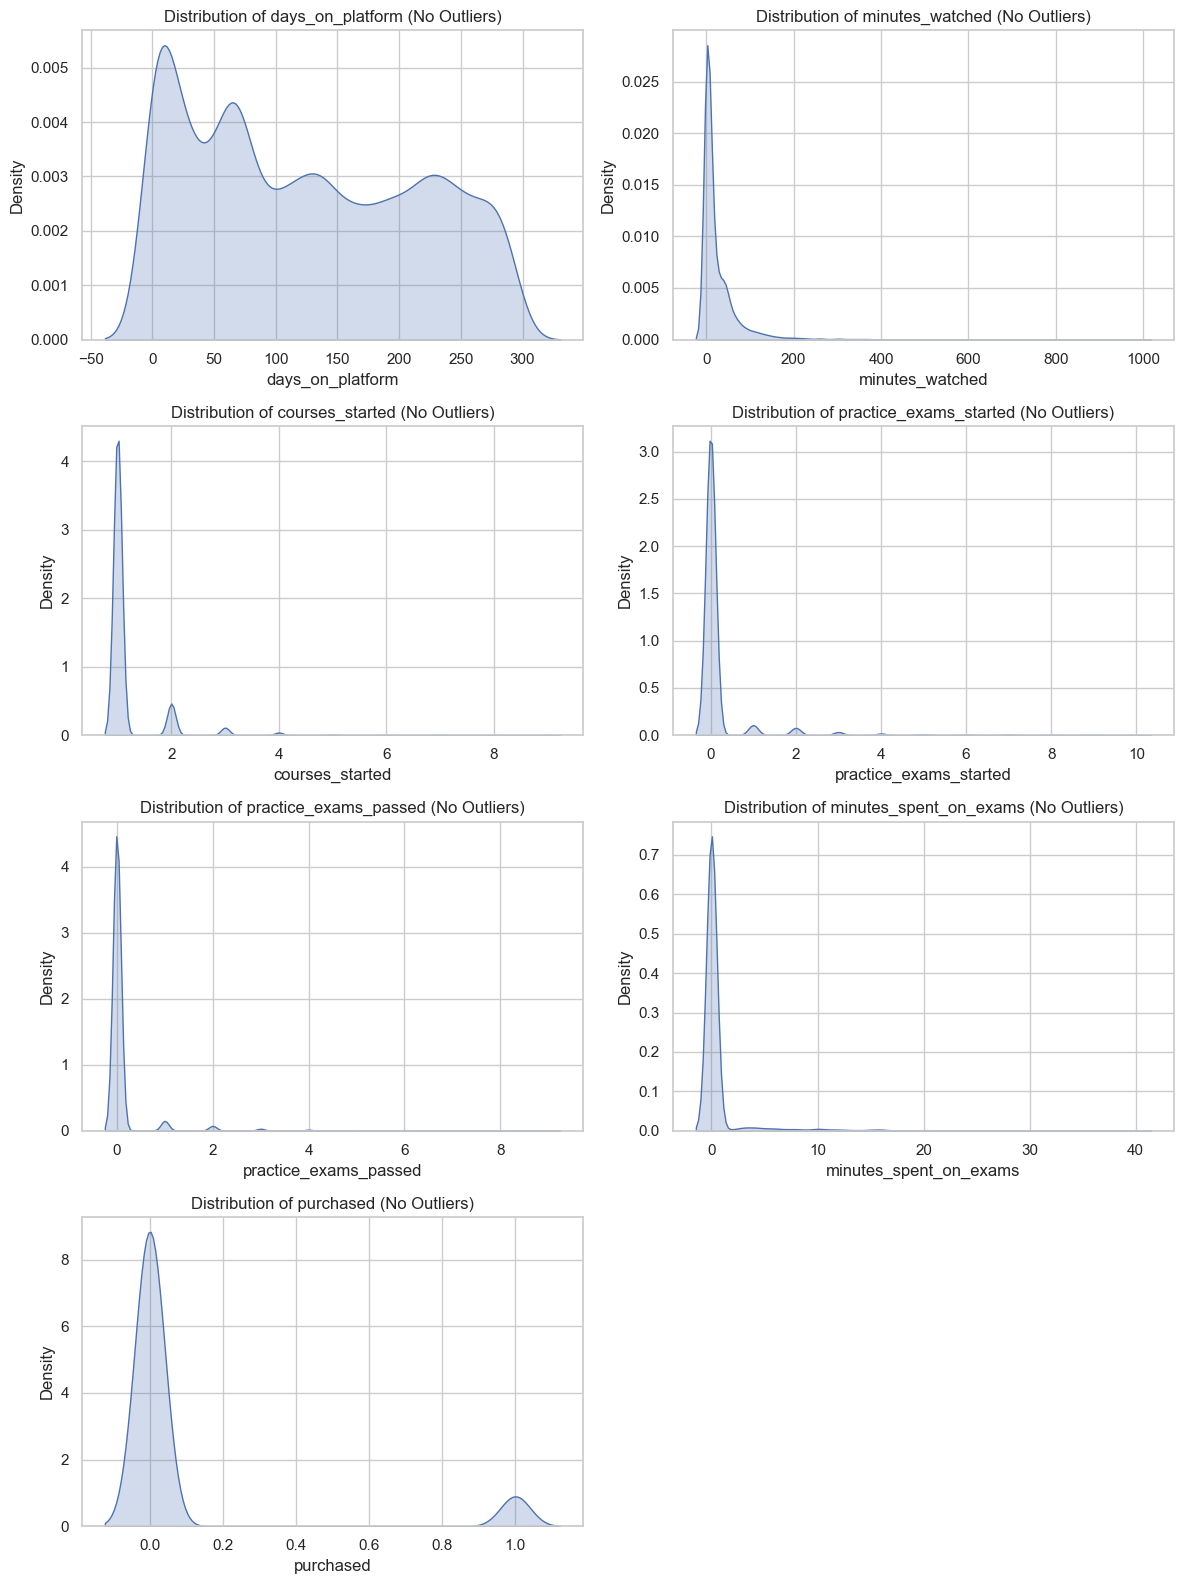

In [78]:
# Step 1: Get the number of features
num_features = len(numerical_features)

# Step 2: Dynamically determine rows & columns
rows = (num_features // 2) + (num_features % 2 > 0)  # Ensures enough rows
cols = min(2, num_features)  # Max 2 columns

# Step 3: Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))  # Adjust height dynamically
axes = axes.flatten()  # Convert to 1D array for easier indexing

# Step 4: Plot KDE distributions for the filtered dataset
for i, feature in enumerate(numerical_features):
    if feature in data_no_outliers.columns:  # Avoid KeyError
        sns.kdeplot(data=data_no_outliers[feature], ax=axes[i], fill=True)
        axes[i].set_title(f"Distribution of {feature} (No Outliers)")
    else:
        print(f"Warning: '{feature}' not found in dataset.")

# Step 5: Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Checking for Multicollinearity

In [79]:

# Step 1: Copy the dataset and select only numerical columns
data_no_mult = data_no_outliers.select_dtypes(include=[np.number]).copy()

# Step 2: Handle NaN values (fill or drop)
data_no_mult = data_no_mult.fillna(0)  # Replace NaN with 0 (or use .dropna())

# Step 3: Convert all data to float64 (ensures compatibility with VIF)
data_no_mult = data_no_mult.astype(float)

# Step 4: Define function to calculate VIF
def calculate_vif(df):
    """Calculates the Variance Inflation Factor (VIF) for each numerical feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Step 5: Iteratively remove features with the highest VIF (>5)
while True:
    vif_df = calculate_vif(data_no_mult)
    print("\nVIF values:\n", vif_df)

    # Identify the feature with the highest VIF
    max_vif_feature = vif_df.loc[vif_df["VIF"].idxmax()]

    # If the highest VIF is greater than 5, remove the feature
    if max_vif_feature["VIF"] > 5:
        print(f"Removing feature '{max_vif_feature['Feature']}' with VIF={max_vif_feature['VIF']:.2f}")
        data_no_mult = data_no_mult.drop(columns=[max_vif_feature["Feature"]])
    else:
        break  # Stop when all VIF values are ≤ 5

# Step 6: Display final VIF values after removing multicollinear features
print("\nFinal VIF values (All ≤ 5):\n", calculate_vif(data_no_mult))

data_no_mult.head(5)


VIF values:
                   Feature        VIF
0        days_on_platform   2.494163
1         minutes_watched   1.814420
2         courses_started   3.504408
3  practice_exams_started  10.206234
4   practice_exams_passed   7.829732
5  minutes_spent_on_exams   3.355225
6               purchased   1.229006
Removing feature 'practice_exams_started' with VIF=10.21

VIF values:
                   Feature       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475

Final VIF values (All ≤ 5):
                   Feature       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475


,days_on_platform,minutes_watched,courses_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,288.0,358.1,1.0,2.0,15.81,0.0
1,260.0,1.7,1.0,0.0,16.00,0.0
2,260.0,22.4,1.0,0.0,0.93,0.0
3,259.0,18.8,1.0,1.0,14.63,0.0
4,259.0,118.0,2.0,1.0,16.48,0.0


### Dealing with NaN Values

In [80]:
# Step 1: Work with raw_data (original dataset)
data_no_nulls = data_no_outliers.copy()

# Step 2: Check if 'student_country' exists and has NaN values
if 'student_country' in data_no_nulls.columns:
    print("Before replacing NaN values:")
    print(data_no_nulls['student_country'].isnull().sum())

    # Step 3: Replace NaN values with 'NAM' (Namibia)
    data_no_nulls['student_country'] = data_no_nulls['student_country'].fillna('NAM')

    # Step 4: Confirm that all NaN values are removed
    print("After replacing NaN values:")
    print(data_no_nulls['student_country'].isnull().sum())
else:
    print("Column 'student_country' not found in raw_data.")

data_no_nulls.head(5)

Before replacing NaN values:
8
After replacing NaN values:
0


,student_country,days_on_platform,minutes_watched,courses_started,practice_exams_started,practice_exams_passed,minutes_spent_on_exams,purchased
0,US,288,358.1,1,2,2,15.81,0
1,SG,260,1.7,1,1,0,16.00,0
2,TR,260,22.4,1,1,0,0.93,0
3,KE,259,18.8,1,1,1,14.63,0
4,IN,259,118.0,2,2,1,16.48,0


### Splitting the Data

In [81]:
from sklearn.model_selection import train_test_split

# Step 1: Define Inputs (X) and Target (y)
X = data_no_nulls.drop(columns=["purchased"])  # Inputs (all features except 'purchased')
y = data_no_nulls["purchased"]  # Target variable (binary classification)

# Step 2: Perform Stratified Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,      # 20% test data
    random_state=365,    # Ensures reproducibility
    stratify=y           # Maintains class distribution in train-test split
)

# Step 3: Print dataset sizes
print("Training set size (X_train):", X_train.shape)
print("Testing set size (X_test):", X_test.shape)
print("Training labels size (y_train):", y_train.shape)
print("Testing labels size (y_test):", y_test.shape)


Training set size (X_train): (14100, 7)
Testing set size (X_test): (3526, 7)
Training labels size (y_train): (14100,)
Testing labels size (y_test): (3526,)


### Encoding the Data

In [82]:
from sklearn.preprocessing import OrdinalEncoder

# Step 1: Initialize the OrdinalEncoder
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=170)

# Step 2: Fit and Transform Training Data
X_train["student_country_enc"] = enc.fit_transform(X_train["student_country"].to_numpy().reshape(-1, 1))

# Step 3: Transform Testing Data
X_test["student_country_enc"] = enc.transform(X_test["student_country"].to_numpy().reshape(-1, 1))

# Step 4: Drop the original 'student_country' column
X_train.drop(columns=["student_country"], inplace=True)
X_test.drop(columns=["student_country"], inplace=True)


In [83]:
# Step 1: Convert to NumPy Arrays
X_train_array = np.asarray(X_train, dtype='float')
y_train_array = np.asarray(y_train, dtype='int')
X_test_array = np.asarray(X_test, dtype='float')
y_test_array = np.asarray(y_test, dtype='int')

# Step 2: Print final shapes
print("X_train_array shape:", X_train_array.shape)
print("X_test_array shape:", X_test_array.shape)
print("y_train_array shape:", y_train_array.shape)
print("y_test_array shape:", y_test_array.shape)


X_train_array shape: (14100, 7)
X_test_array shape: (3526, 7)
y_train_array shape: (14100,)
y_test_array shape: (3526,)


### Creating a Logistic Regression Model

In [84]:
import statsmodels.api as sm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np


In [85]:
# Check for NaN values
print("NaN values in X_train_array:", np.isnan(X_train_array).sum())

# Check for infinite values
print("Infinite values in X_train_array:", np.isinf(X_train_array).sum())


NaN values in X_train_array: 0
Infinite values in X_train_array: 0


In [86]:
# Step 1: Set up the logistic regression model
log_reg = sm.Logit(y_train_array, X_train_array)

# Step 2: Fit the model
log_reg_results = log_reg.fit()

# Step 3: Print model summary
print(log_reg_results.summary())


Optimization terminated successfully.
         Current function value: 0.152504
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14093
Method:                           MLE   Df Model:                            6
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                  0.5039
Time:                        14:03:40   Log-Likelihood:                -2150.3
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0693      0.002    -31.890      0.000      -0.074      -0.065
x2             0.0147      0

In [87]:
# Step 1: Predict probabilities on the test set
y_pred_prob = log_reg_results.predict(X_test_array)

# Step 2: Convert probabilities to class predictions (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)


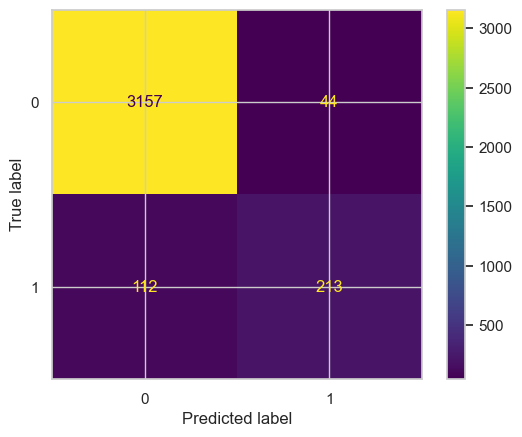

In [88]:
# Step 1: Compute the confusion matrix
cm = confusion_matrix(y_test_array, y_pred)

# Step 2: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [89]:
# Extract False Positives (FP)
false_positives = cm[0, 1]  # First row, second column

print("Number of False Positives:", false_positives)


Number of False Positives: 44


### Creating a K-Nearest Neighbors Model

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np


In [91]:
# Define the range of hyperparameters
parameters_knn = {
    'n_neighbors': np.arange(1, 51),  # Number of neighbors from 1 to 50
    'weights': ['uniform', 'distance']  # Two types of weighting
}


In [92]:
# Initialize the Grid Search with KNN classifier
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),  # Model to optimize
    parameters_knn,          # Hyperparameter grid
    scoring='accuracy',      # Optimize based on accuracy
    cv=5,                    # 5-fold cross-validation
    n_jobs=-1,               # Use all processors for parallel computation
    verbose=1                # Show progress
)


In [93]:
# Fit the grid search to training data
grid_search_knn.fit(X_train_array, y_train_array)

# Get the best model
knn_clf = grid_search_knn.best_estimator_

# Print the best parameters found
print("Best Parameters for KNN:", grid_search_knn.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for KNN: {'n_neighbors': np.int64(7), 'weights': 'uniform'}


In [94]:
# Predict on test data using the best KNN model
y_test_pred_knn = knn_clf.predict(X_test_array)


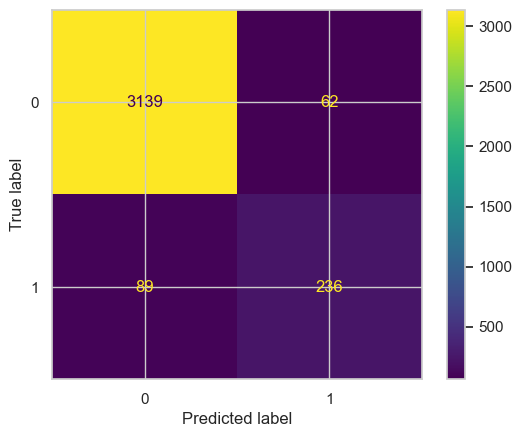

In [95]:
# Compute confusion matrix
cm_knn = confusion_matrix(y_test_array, y_test_pred_knn)

# Display confusion matrix
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()


In [96]:
# Generate classification report
print("Classification Report for KNN:\n", classification_report(y_test_array, y_test_pred_knn))


Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.79      0.73      0.76       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.87      3526
weighted avg       0.96      0.96      0.96      3526



In [97]:
report = classification_report(y_test_array, y_test_pred_knn)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.79      0.73      0.76       325

    accuracy                           0.96      3526
   macro avg       0.88      0.85      0.87      3526
weighted avg       0.96      0.96      0.96      3526



In [98]:
from pprint import pprint
report_dict = classification_report(y_test_array, y_test_pred_knn, output_dict=True)
pprint(report_dict)

{'0': {'f1-score': 0.976512676932649,
       'precision': 0.9724287484510533,
       'recall': 0.9806310527960013,
       'support': 3201.0},
 '1': {'f1-score': 0.7576243980738363,
       'precision': 0.7919463087248322,
       'recall': 0.7261538461538461,
       'support': 325.0},
 'accuracy': 0.9571752694271128,
 'macro avg': {'f1-score': 0.8670685375032426,
               'precision': 0.8821875285879428,
               'recall': 0.8533924494749237,
               'support': 3526.0},
 'weighted avg': {'f1-score': 0.9563372116379484,
                  'precision': 0.9557932428041385,
                  'recall': 0.9571752694271128,
                  'support': 3526.0}}


In [99]:
### For single Model
import mlflow

In [100]:
# mlflow.set_experiment("First Experiment")
# mlflow.set_tracking_uri("http://127.0.0.1:5000/")
#
# with mlflow.start_run(run_name="First Experiment"):
#     mlflow.log_param("n_neighbors", grid_search_knn.best_params_["n_neighbors"])
#     mlflow.log_metrics({
#         'accuracy': report_dict['accuracy'],
#         'recall_for_class_0': report_dict['0']['recall'],
#         'recall_for_class_1': report_dict['1']['recall'],
#         'f1_score_macro avg': report_dict['macro avg']['f1-score'],
#     })
#     mlflow.sklearn.log_model(knn_clf, "knn")

### Creating a Support Vector Machines Model

In [101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np


In [102]:
# Initialize MinMaxScaler with range (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_array)

# Transform the test data (do not fit again!)
X_test_scaled = scaler.transform(X_test_array)


In [103]:
# Define the range of hyperparameters for GridSearchCV
parameters_svm = {
    'kernel': ['linear', 'poly', 'rbf'],  # Different kernel types
    'C': np.arange(1, 11),                # C values from 1 to 10
    'gamma': ['scale', 'auto']             # Gamma settings
}


In [104]:
# Initialize GridSearchCV with SVC classifier
grid_search_svm = GridSearchCV(
    SVC(),                 # SVM model
    parameters_svm,        # Hyperparameter grid
    scoring='accuracy',    # Optimize for accuracy
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # Use all processors for parallel computation
    verbose=1             # Show progress
)


In [105]:
# Fit the Grid Search to training data
grid_search_svm.fit(X_train_scaled, y_train_array)

# Get the best model
svm_clf = grid_search_svm.best_estimator_

# Print the best parameters found
print("Best Parameters for SVM:", grid_search_svm.best_params_)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters for SVM: {'C': np.int64(5), 'gamma': 'scale', 'kernel': 'poly'}


In [106]:
# Predict on test data using the best SVM model
y_test_pred_svm = svm_clf.predict(X_test_scaled)


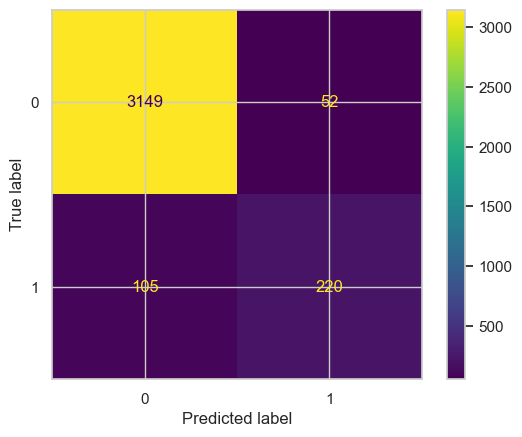

In [107]:
# Compute confusion matrix
cm_svm = confusion_matrix(y_test_array, y_test_pred_svm)

# Display confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()


In [108]:
# Generate classification report
print("Classification Report for SVM:\n", classification_report(y_test_array, y_test_pred_svm))


Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3201
           1       0.81      0.68      0.74       325

    accuracy                           0.96      3526
   macro avg       0.89      0.83      0.86      3526
weighted avg       0.95      0.96      0.95      3526



### Creating a Decision Trees Model

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


In [110]:
# Define the hyperparameter grid for ccp_alpha (cost complexity pruning)
parameters_dt = {
    'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]  # Pruning values
}


In [111]:
# Initialize GridSearchCV with DecisionTreeClassifier
grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=365),  # Set random state for reproducibility
    parameters_dt,                            # Hyperparameter grid
    scoring='accuracy',                       # Optimize based on accuracy
    cv=5,                                     # 5-fold cross-validation
    n_jobs=-1,                                # Use all processors for parallel computation
    verbose=1                                 # Show progress
)


In [112]:
# Fit the Grid Search to non-scaled training data
grid_search_dt.fit(X_train_array, y_train_array)

# Get the best model
dt_clf = grid_search_dt.best_estimator_

# Print the best parameters found
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Decision Tree: {'ccp_alpha': 0.001}


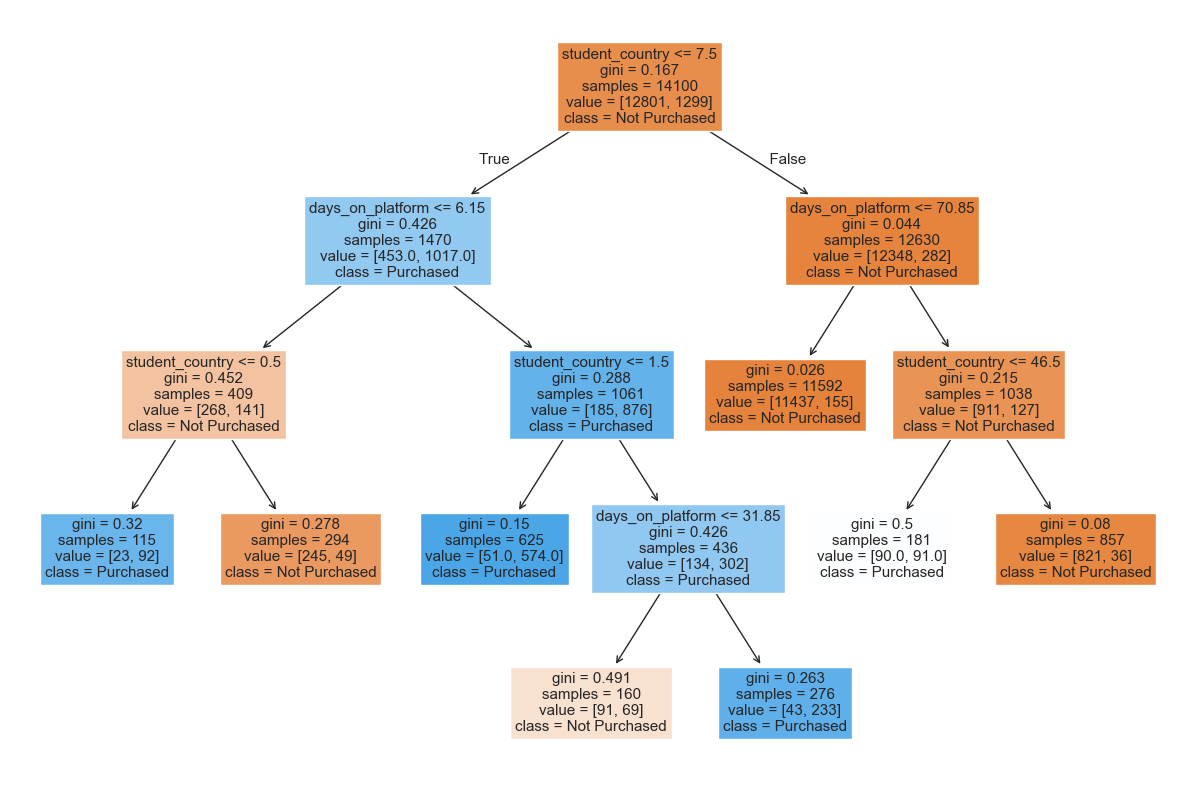

In [113]:
# Set figure size
plt.figure(figsize=(15,10))

# Plot the decision tree
plot_tree(
    dt_clf,
    filled=True,                # Color nodes based on class purity
    feature_names=X.columns,    # Use feature names for labels
    class_names=['Not Purchased', 'Purchased']  # Label classes
)

# Display the plot
plt.show()


In [114]:
# Predict on test data using the best decision tree model
y_test_pred_dt = dt_clf.predict(X_test_array)


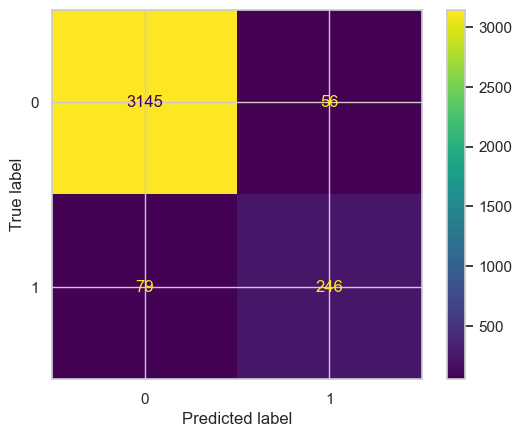

In [115]:
# Compute confusion matrix
cm_dt = confusion_matrix(y_test_array, y_test_pred_dt)

# Display confusion matrix
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot()


In [116]:
# Generate classification report
print("Classification Report for Decision Tree:\n", classification_report(y_test_array, y_test_pred_dt))


Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3201
           1       0.81      0.76      0.78       325

    accuracy                           0.96      3526
   macro avg       0.90      0.87      0.88      3526
weighted avg       0.96      0.96      0.96      3526



### Creating a Random Forests Model

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


In [118]:
# Retrieve the best ccp_alpha from the previous Decision Tree model
best_ccp_alpha = grid_search_dt.best_params_['ccp_alpha']

print("Best ccp_alpha for Random Forest:", best_ccp_alpha)


Best ccp_alpha for Random Forest: 0.001


In [119]:
# Initialize the Random Forest classifier with the best ccp_alpha value
rf_clf = RandomForestClassifier(
    ccp_alpha=best_ccp_alpha,  # Use the best pruning value from Decision Tree
    random_state=365           # Ensure reproducibility
)

# Fit the model using the training data
rf_clf.fit(X_train_array, y_train_array)


RandomForestClassifier(ccp_alpha=0.001, random_state=365)

In [120]:
# Predict on test data using the trained Random Forest model
y_test_pred_rf = rf_clf.predict(X_test_array)


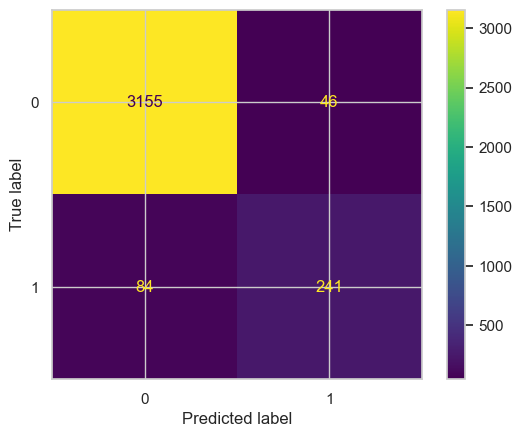

In [121]:
# Compute confusion matrix
cm_rf = confusion_matrix(y_test_array, y_test_pred_rf)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()


In [122]:
# Generate classification report
print("Classification Report for Random Forest:\n", classification_report(y_test_array, y_test_pred_rf))


Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3201
           1       0.84      0.74      0.79       325

    accuracy                           0.96      3526
   macro avg       0.91      0.86      0.88      3526
weighted avg       0.96      0.96      0.96      3526



In [123]:

import mlflow.sklearn

# Set up MLflow experiment and tracking URI
mlflow.set_experiment("First Experiment")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

# Dictionary to store models and their names
models = {
    "KNN": (knn_clf, grid_search_knn.best_params_),
    "SVM": (svm_clf, grid_search_svm.best_params_),
    "Decision Tree": (dt_clf, grid_search_dt.best_params_),
    "Random Forest": (rf_clf, {"ccp_alpha": best_ccp_alpha}),
}

# Loop through models and log each one separately
for model_name, (model, params) in models.items():
    with mlflow.start_run(run_name=model_name):  # Different run for each model
        # Log hyperparameters
        for param_name, param_value in params.items():
            mlflow.log_param(param_name, param_value)

        # Log metrics
        report_dict = classification_report(y_test_array, model.predict(X_test_array), output_dict=True)
        mlflow.log_metrics({
            'accuracy': report_dict['accuracy'],
            'recall_for_class_0': report_dict['0']['recall'],
            'recall_for_class_1': report_dict['1']['recall'],
            'f1_score_macro avg': report_dict['macro avg']['f1-score'],
        })

        # Log model artifact
        mlflow.sklearn.log_model(model, model_name)

print("All models logged successfully!")


2025/02/17 14:04:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN at: http://127.0.0.1:5000/#/experiments/561637249157547215/runs/d5dea8223d4d43408954bf6350d53d34
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/561637249157547215


2025/02/17 14:04:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVM at: http://127.0.0.1:5000/#/experiments/561637249157547215/runs/558fccba2ba640e191b84494172a9c66
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/561637249157547215


2025/02/17 14:04:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Decision Tree at: http://127.0.0.1:5000/#/experiments/561637249157547215/runs/73cdbd6a4a034f70b60428d557c34925
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/561637249157547215


2025/02/17 14:04:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/561637249157547215/runs/033a2524d376400891b76cdef4250c59
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/561637249157547215
All models logged successfully!
